In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

from scipy.io import savemat, loadmat

In [2]:
Jfolder = '/mnt/e/Placement-Control-Optim-CO2/Johansen/data'

actnum = np.loadtxt('{}/NPD5_ActiveCells.txt'.format(Jfolder), skiprows=1).flatten().reshape(100,100,11, order='F')
actnum_pad = np.pad(actnum, ((14,14),(14,14),(2,3)), mode='constant', constant_values=0)

actnum_l1 = actnum[...,0]
indexMap = np.argwhere(actnum_l1.flatten(order='F')).flatten(order='F')

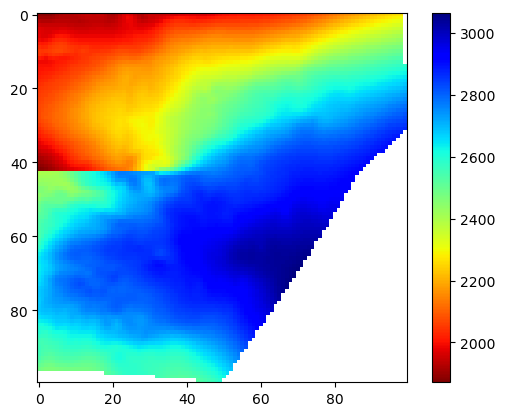

In [53]:
tops = loadmat('data_100_100_11/Gt_cells_z.mat', simplify_cells=True)['gtz']

tops_grid = np.zeros((100,100))
tops_grid_f = tops_grid.flatten()
tops_grid_f[indexMap] = tops

tops_grid = tops_grid_f.reshape(100,100, order='F')
tops_grid_masked = np.ma.masked_where(actnum_l1==0, tops_grid)

plt.imshow(tops_grid_masked, cmap='jet_r')
plt.colorbar()

In [36]:
n_realizations = 10
timesteps = []
saturation_f = np.zeros((n_realizations,31,8072))
pressure_f   = np.zeros((n_realizations,31,8072))

sec2year = 365.25 * 24 * 60 * 60


for i in range(n_realizations):
    d = loadmat('data_100_100_11/states/states_{}.mat'.format(i+1), simplify_cells=True)['var']
    for t in range(len(d)):
        saturation_f[i,t] = d[t]['s'][:,1]
        pressure_f[i,t]   = d[t]['pressure']

for t in range(1,31):
    d = loadmat('data_100_100_11/states/states_0.mat', simplify_cells=True)['var']
    timesteps.append(d[t]['time']/sec2year)
timesteps = [0] + timesteps

In [48]:
saturation = np.zeros((n_realizations, len(timesteps), 100*100))
pressure   = np.zeros((n_realizations, len(timesteps), 100*100))

for i in range(n_realizations):
    for t in range(len(timesteps)):
        saturation[i,t][indexMap] = saturation_f[i,t]
        pressure[i,t][indexMap]   = pressure_f[i,t]

saturation = saturation.reshape(n_realizations, len(timesteps), 100, 100)
pressure   = pressure.reshape(n_realizations, len(timesteps), 100, 100)
print(saturation.shape, pressure.shape)

(10, 31, 100, 100) (10, 31, 100, 100)


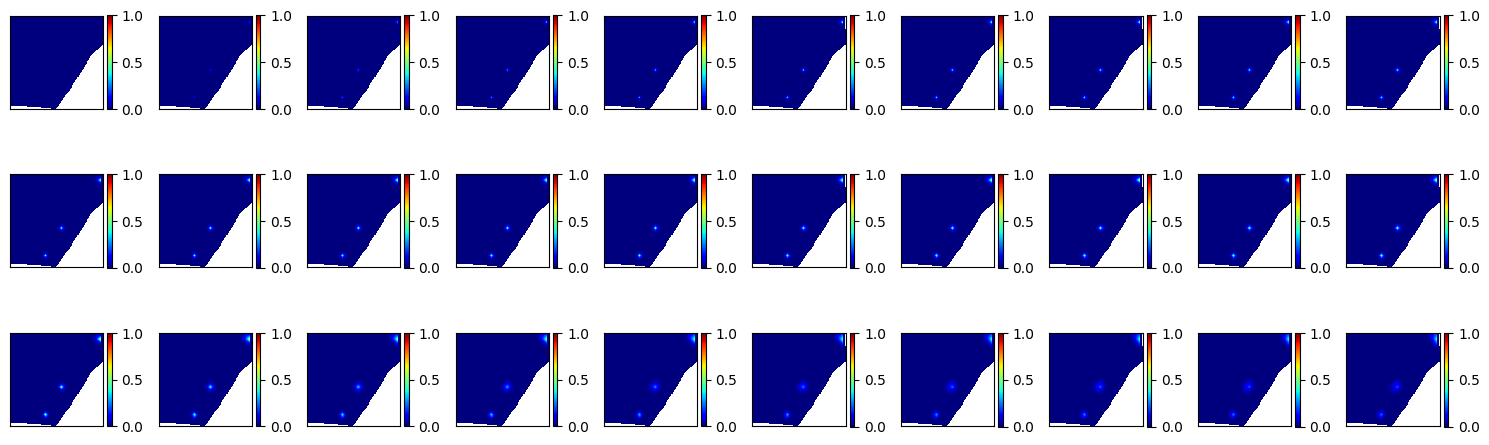

In [51]:
plt.figure(figsize=(15,5))
k = 0
for i in range(3):
    for j in range(10):
        plt.subplot(3,10,k+1)
        sat_masked = np.ma.masked_where(actnum_l1==0, saturation[5,k])
        im = plt.imshow(sat_masked, cmap='jet', vmin=0, vmax=1)
        plt.colorbar(im, pad=0.04, fraction=0.046)
        plt.xticks([]); plt.yticks([])
        k += 1
plt.tight_layout()
plt.show()

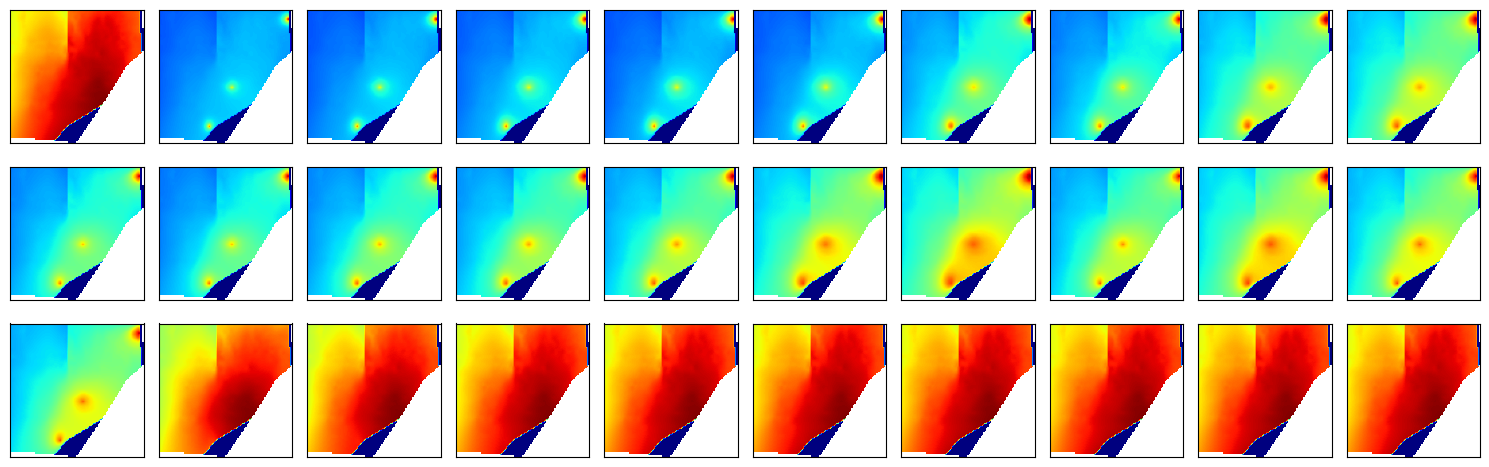

In [52]:
plt.figure(figsize=(15,5))
k = 0
for i in range(3):
    for j in range(10):
        plt.subplot(3,10,k+1)
        pres_masked = np.ma.masked_where(actnum_l1==0, pressure[5,k])
        plt.imshow(pres_masked, cmap='jet')
        plt.xticks([]); plt.yticks([])
        k += 1
plt.tight_layout()
plt.show()

In [138]:
nwells  = len(d[1]['wellSol'])
co2_rho = 686.5266
mega    = 1e6

wrate = np.zeros((30, nwells))
for t in range(1,30):
    wrate[t-1] = d[t]['wellSol']['val'] / mega / 1e3 * sec2year * co2_rho

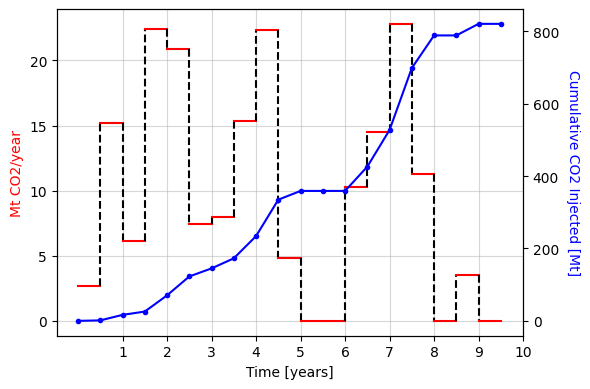

In [139]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax2 = ax.twinx()

for t in range(1,20):
    ax.plot([timesteps[t-1], timesteps[t]], [wrate[t,0], wrate[t,0]], 'r')
    ax.vlines(timesteps[t], wrate[t,0], wrate[t+1,0], ls='--', color='k')
ax.set(xlabel='Time [years]')
ax.set_ylabel('Mt CO2/year', c='r')

ax2.plot(timesteps[:20], np.cumsum(wrate[:20,0]*timesteps[:20]), color='b', marker='.')
ax2.set_ylabel('Cumulative CO2 Injected [Mt]', color='b', rotation=270, labelpad=15)

ax.set(xticks=range(1,11), xticklabels=range(1,11))
ax.grid(True, which='both', alpha=0.5)
plt.tight_layout()
plt.show()

In [75]:
report = loadmat('data_100_100_11/reports/reports_21.mat', simplify_cells=True)['var']
sec2year = 365.25 * 24 * 60 * 60
mt_of_co2 = 686.5266 * 1e6

t = []
for i in range(31):
    t.append(report[i]['t']/sec2year)

m = np.zeros((31,8))
for i in range(31):
    for j in range(8):
        m[i,j] = report[i]['masses'][j] / mt_of_co2

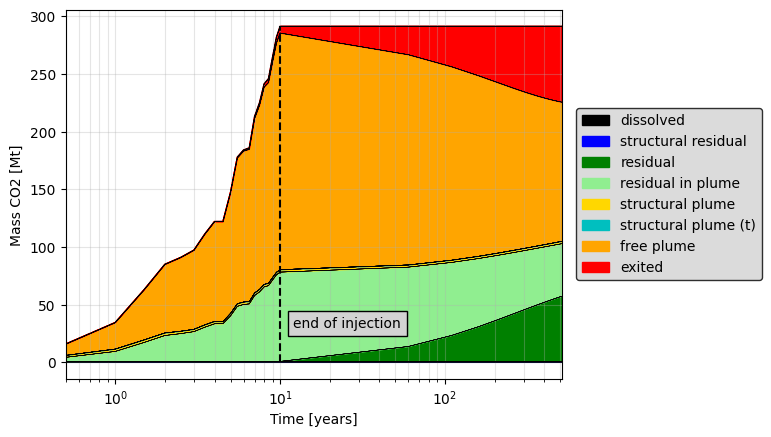

In [76]:
colors = ['k','blue','green','lightgreen','gold','c','orange','r']
labels = ['dissolved','structural residual', 'residual','residual in plume','structural plume', 'structural plume (t)','free plume', 'exited']

for i in range(8):
    plt.plot(t, np.cumsum(m, axis=1), color='k', lw=0.25)
    plt.fill_between(t, np.cumsum(m, axis=1)[:,i], np.cumsum(m, axis=1)[:,i-1], label=labels[i], color=colors[i])

plt.vlines(10, 0, np.cumsum(m,1).max(), color='k', ls='--')
plt.text(12, 30, 'end of injection', bbox=dict(facecolor='lightgray', edgecolor='k'))

plt.xscale('log')
plt.xlim(0.5, 510)
plt.legend(bbox_to_anchor=(1.015, 0.5), loc='center left', facecolor='lightgrey', edgecolor='k')
plt.xlabel('Time [years]'); plt.ylabel('Mass CO2 [Mt]')
plt.grid(True, which='both', alpha=0.33)
plt.show()